In [102]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [103]:
import cv2
import numpy as np
import logging
import math
import csv
import random

### Display Methods

In [2]:
def display_frame(cap, index):
    ''' Display a frame from a video capture stream. '''
    frame = get_frame(cap, index)
    display_image(frame)

In [3]:
def display_image(image):
    ''' Show an image in a matplotlib figure. '''
    # If colored, swap color order to RGB
    if len(image.shape) > 2:
        image = image[:,:,[2,1,0]]
        imshow(image)
    else:
        imshow(image, cmap=cm.Greys)

In [4]:
def image_rows(images, ncols=4):
    matrix = []
    for i in xrange(0, len(images), ncols):
        matrix.append(images[i:i+ncols])
    image_matrix(matrix)

In [5]:
def image_matrix(images, imgsize=(8, 5), save=False):
    ''' Show matrix of images of variable size. '''
    if len(images) == 0 or len(images[0]) == 0:
        return
    rows = len(images)
    cols = len(images[0])
    w, h = imgsize
    figure(figsize=(w * cols, h * rows))
    for r, row in enumerate(images):
        for c, img in enumerate(row):
            spn = r * cols + c + 1
            subplot(rows, cols, spn)
            display_image(img)
    if save:
        savefig('results.png')

In [6]:
def draw_rectangle(image, rect):
    ''' Draw a rectangle on an image. '''
    l, t, w, h = rect
    cv2.rectangle(image, 
        (l, t),
        (l + w, t + h), 
        (0, 255, 0), 10)

### Video Stream Methods

In [7]:
''' Helpers for fetching specific frames. '''
get_findex = lambda cap : int(cap.get(cv2.cv.CV_CAP_PROP_POS_FRAMES))
set_findex = lambda cap, f : cap.set(cv2.cv.CV_CAP_PROP_POS_FRAMES, f)

In [8]:
def get_frame(cap, index):
    ''' Modified from code on SO question, "How to process images of a video, frame 
        by frame in video streaming using Opencv python "'''
    
    set_findex(cap, index)    
    logging.debug("Fetching frame %d", index)

    while True:
        flag, frame = cap.read()    
        if flag:
            logging.debug("Got frame %d", index)
            return frame
            break
        else:
            logging.debug("Frame %d not ready, trying again", index)
            # The frame number increments after a read attempt.
            # Furthermore, to try to read frame i, we set frame number to i + 1.
            # I don't know why, but this is just how the API works.
            index = get_findex(cap)
            set_findex(cap, index)
            cv2.waitKey(500)

# Main Tests

###Preparation

Load video streams

In [16]:
video_path = 'videos/1--MBS2YvUY2M-Android_Facebook_Login_integration_with_Eclipse..mp4'
stream = cv2.VideoCapture(video_path)

Load test data

In [17]:
with open('events.csv') as datafile:
    data = csv.DictReader(datafile, )
    records = []
    for r in data:
        records.append(r)

In [18]:
events = []

for r in records:

    # Get video and frame index
    eindex = int(r['Eindex'])
    frame_index = int(r['Frame'])
    
    # Store as more readable event dictionary
    event = {
        'event_index': eindex,
        'frame_index': frame_index,
    }
    events.append(event)

### Compute recent difference at each frame

Demonstrate the overall logic of our loop

In [19]:
diffs = []
window = 10
last_frame = None

for i in range(1, 101):  # change me
    
    if len(diffs) >= window:
        diffs.pop(0)
    
    frame = i
    if last_frame is not None:
        diff = float(frame) / last_frame  # change me
        diffs.append(diff)

    last_frame = frame
    # print diffs

Compute the difference at every frame of the colors found in recent frames

In [22]:
def diff_frames(cap, window=10, report=100):
    '''
    Compute the sum of differences in all frame steps in a fixed window 
    leading up to a frame.  Used to estimate likelihood that a major UI
    change has just occurred in a video.
    Returns a vector the length of the number of frames in the video.
    '''
    diffs = []
    diff_sums = []
    frame_count = int(cap.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT))
    last_frame = None

    for fi in range(0, frame_count + 1):

        if (fi % report == 0):
            print "Processing frame %d / %d" % (fi, frame_count)

        # Keep the size of the window of recent differences steady
        if len(diffs) >= window:
            diffs.pop(0)

        # Compute diff between new frame and last
        # Cast frame to int16 so we can store negative differences between frames
        frame = get_frame(cap, fi).astype('int16')
        if last_frame is not None:
            diff = frame - last_frame  # should this be signed???
            diffs.append(diff)         

        # Compute the sum of recent differences at this frame
        diff_window = np.array(diffs)
        diff_sum = np.sum(diff_window)  # overflow worry?
        diff_sums.append(diff_sum)
        
        last_frame = frame
        
    return diff_sums

In [23]:
diff_sums = diff_frames(stream)

Processing frame 0 / 18197
Processing frame 100 / 18197
Processing frame 200 / 18197
Processing frame 300 / 18197
Processing frame 400 / 18197
Processing frame 500 / 18197
Processing frame 600 / 18197
Processing frame 700 / 18197
Processing frame 800 / 18197
Processing frame 900 / 18197
Processing frame 1000 / 18197
Processing frame 1100 / 18197
Processing frame 1200 / 18197
Processing frame 1300 / 18197
Processing frame 1400 / 18197
Processing frame 1500 / 18197
Processing frame 1600 / 18197
Processing frame 1700 / 18197
Processing frame 1800 / 18197
Processing frame 1900 / 18197
Processing frame 2000 / 18197
Processing frame 2100 / 18197
Processing frame 2200 / 18197
Processing frame 2300 / 18197
Processing frame 2400 / 18197
Processing frame 2500 / 18197
Processing frame 2600 / 18197
Processing frame 2700 / 18197
Processing frame 2800 / 18197
Processing frame 2900 / 18197
Processing frame 3000 / 18197
Processing frame 3100 / 18197
Processing frame 3200 / 18197
Processing frame 3300 

Oops, the first frame is actually frame 1

In [150]:
diff_sums = diff_sums[1:]

Verify that we have the same number of differences as the number of frames

In [151]:
print "Frame count: %d" % int(stream.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT))
print "Difference count: %d" % len(diff_sums)

Frame count: 18197
Difference count: 18197


### Report on overall trends in pixel differences

The time series of differences measured at each frame

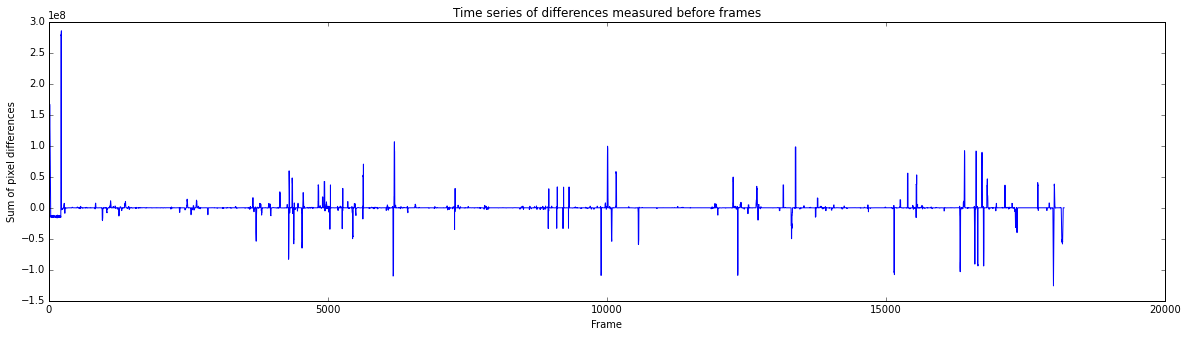

In [27]:
figure(figsize=(20,5))
plot(diff_sums)
title("Time series of differences measured before frames")
xlabel("Frame")
ylabel("Sum of pixel differences")

All frames from 1-217 and 17997-end should be cleaned out as these are highly noisy video effects.

We also define a function that will take in the original frame index and return the index in this cleaner array.

In [155]:
all_diff_sums = diff_sums
diff_sums = diff_sums[217:17997]

In [219]:
di = lambda f: f - 218  # frame index to diff index
fi = lambda d: d + 218  # diff index to frame index

Distribution statistics for the differences measured

In [158]:
print "====== Difference distribution ======"
print "Mean: %.f" % np.average(diff_sums)
print "Median: %.f" % np.median(diff_sums)
print "St. Dev.: %.f" % np.std(diff_sums)
print "Min: %.f" % np.min(diff_sums)
print "Max: %.f" % np.max(diff_sums)
print ""

print "====== Absolute Difference distribution ======"
abs_diffs = np.abs(diff_sums)
print "Mean: %.f" % np.average(abs_diffs)
print "Median: %.f" % np.median(abs_diffs)
print "St. Dev.: %.f" % np.std(abs_diffs)
print "Min: %.f" % np.min(abs_diffs)
print "Max: %.f" % np.max(abs_diffs)

====== Difference distribution ======
Mean: 128247
Median: -351
St. Dev.: 12157433
Min: -110002073
Max: 285447155

====== Absolute Difference distribution ======
Mean: 2155453
Median: 42654
St. Dev.: 11965519
Min: 0
Max: 285447155


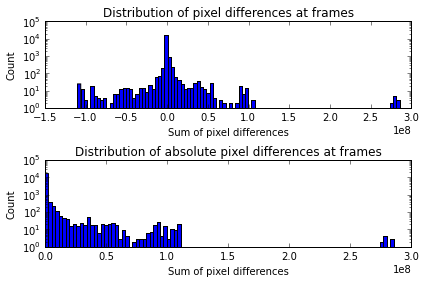

In [159]:
fig = figure()
subplot(2,1,1)
hist(diff_sums, bins=100, log=True)
title("Distribution of pixel differences at frames")
xlabel("Sum of pixel differences")
ylabel("Count")
subplot(2,1,2)
hist(abs_diffs, bins=100, log=True)
title("Distribution of absolute pixel differences at frames")
xlabel("Sum of pixel differences")
ylabel("Count")
fig.tight_layout()

### Report on distribution of differences values at frames of menu event

Extract pixel differences measured at each frame where a menu appearance or disappearance has occurred.

In [220]:
event_diffs = []
for e in events:
    diff = diff_sums[di(e['frame_index'])]
    event_diffs.append(diff)

In [221]:
print "====== Difference distribution ======"
print "Mean: %.f" % np.average(event_diffs)
print "Median: %.f" % np.median(event_diffs)
print "St. Dev.: %.f" % np.std(event_diffs)
print "Min: %.f" % np.min(event_diffs)
print "Max: %.f" % np.max(event_diffs)
print ""

abs_event_diffs = np.abs(event_diffs)
print "====== Absolute Difference distribution ======"
print "Mean: %.f" % np.average(abs_event_diffs)
print "Median: %.f" % np.median(abs_event_diffs)
print "St. Dev.: %.f" % np.std(abs_event_diffs)
print "Min: %.f" % np.min(abs_event_diffs)
print "Max: %.f" % np.max(abs_event_diffs)

====== Difference distribution ======
Mean: 273514
Median: 49387
St. Dev.: 4561340
Min: -11993466
Max: 7143808

====== Absolute Difference distribution ======
Mean: 3406276
Median: 2581413
St. Dev.: 3045967
Min: 49387
Max: 11993466


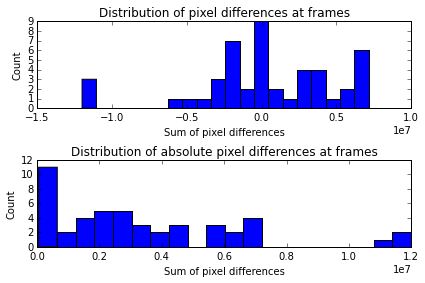

In [222]:
fig = figure()
subplot(2,1,1)
hist(event_diffs, bins=20)
title("Distribution of pixel differences at frames")
xlabel("Sum of pixel differences")
ylabel("Count")
subplot(2,1,2)
a = hist(abs_event_diffs, bins=20)
title("Distribution of absolute pixel differences at frames")
xlabel("Sum of pixel differences")
ylabel("Count")
fig.tight_layout()

Compare the distribution of event differences to all differences

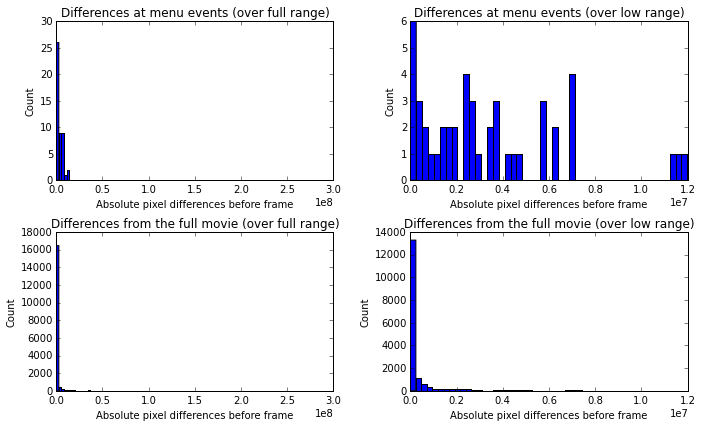

In [223]:
fig = figure(figsize=(10,6))
subplot(2,2,3)
_, all_bins, _ = hist(abs_diffs, bins=100)
title("Differences from the full movie (over full range)")
xlabel("Absolute pixel differences before frame")
ylabel("Count")
subplot(2,2,1)
hist(abs_event_diffs, bins=100, range=(all_bins[0], all_bins[-1]))
title("Differences at menu events (over full range)")
xlabel("Absolute pixel differences before frame")
ylabel("Count")
subplot(2,2,2)
_, ebins, _ = hist(abs_event_diffs, range=(0, np.max(abs_event_diffs)), bins=len(abs_event_diffs))
title("Differences at menu events (over low range)")
xlabel("Absolute pixel differences before frame")
ylabel("Count")
subplot(2,2,4)
hist(abs_diffs, bins=50, range=(ebins[0], ebins[-1]))
title("Differences from the full movie (over low range)")
xlabel("Absolute pixel differences before frame")
ylabel("Count")
fig.tight_layout()

We can clearly see the magnitude of differences for frames where menu events occur has a higher mean and distribution compared to the overall distribution of differences at all frames.

### Predicting UI Events Via Absolute Pixel Difference

If we just use the median value of pixel differences at menu events as a predictor of difference a UI event, we have many more 'event' frames than our ground truth.

In [224]:
print "Ground truth events: %d" % len(events)
print "Frames above threshold: %d" % sum(abs_diffs > 2581413)

Ground truth events: 47
Frames above threshold: 1409


This might be okay, as we compute the differences over 10 frames -- if the biggest difference occurs in just one frame, it would be included 10 frames before and after.  Therefore, we would expect the following number of frames to contain a magnitude above the median:

In [225]:
print "Expected menu event frames containing above-median difference: %d" % ((len(events) / 2) * (10 + 10))  

Expected menu event frames containing above-median difference: 460


What are some of these mystery frames that count as UI events?  Let's take a sample.

In [241]:
event_indexes = np.where(abs_diffs > np.median(abs_event_diffs))[0]

In [242]:
random.seed(0)
rand_events = random.sample(event_indexes, 50)

In [243]:
matrix = []
for e in rand_events:
    frames = []
    for i in xrange(fi(e) - 10, fi(e) + 1, 5):
        frames.append(get_frame(stream, i))
    matrix.append(frames)

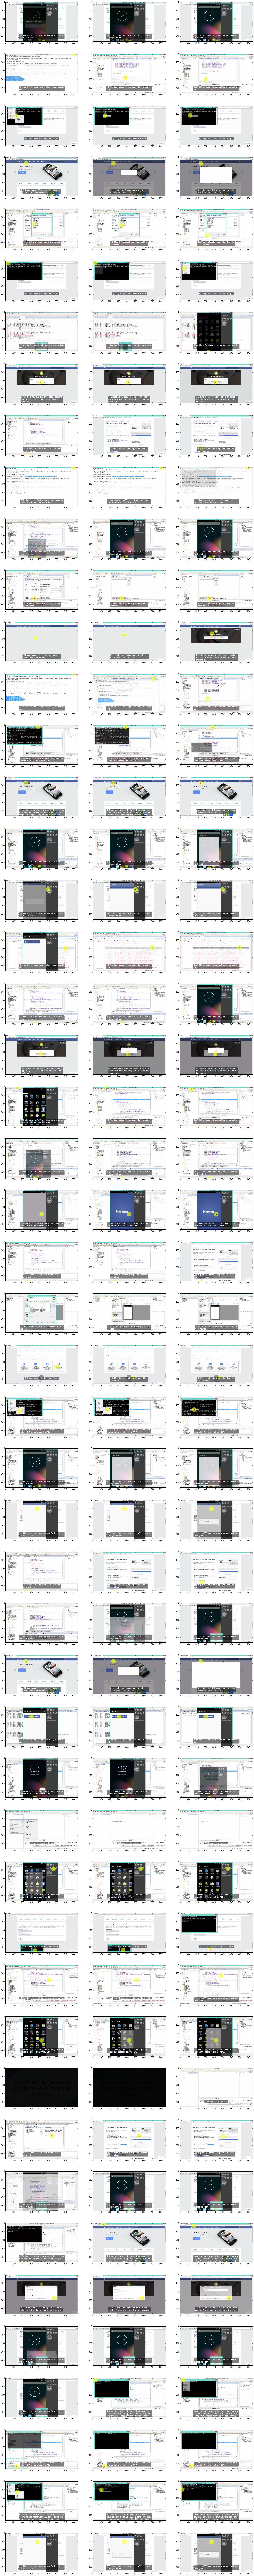

In [244]:
image_matrix(matrix)